# SPRINT 8 - Visualización de datos con Python

In [25]:
# Importa todas las bibliotecas a usar y crea las funciones auxiliares
# que se usarán en este bloc de notas.import configparser
import dateutil
import pandas as pd
import numpy as np

from pandas     import to_datetime
from matplotlib import pyplot, ticker
from s8helpers  import db_connect, column_colors

LF="\n"

# Aquí configurando cosas de genéricas de Pandas
pd.set_option("display.max.columns", None)
pd.options.mode.copy_on_write = True

# Ancilliary functions
def is_defined(varname):
    return varname in globals()

def is_dataFrame(varname):
    return is_defined(varname) \
        and type(globals().get(varname)) is pd.core.frame.DataFrame

db = db_connect()


Conectado!


## Tarea S08.01

### Nivel 1
Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.

<div class="alert alert-block alert-warning">

**NOTA:**  
Esta descripción es un tanto confusa: Python **NO** se conecta con *MySQL Workbench*; se puede conectar con el **servidor** de base de datos (RDBMS: _Relational DataBase Management Server_) MySQL (o MariaDB, o PostgreSQL, o...). *MySQL Workbench* es un **cliente** (que sí, puede gestionar el servidor) que se conecta al RDBMS, igual que lo hará Python.  
Puede que parezca "más fácil de entender", pero sigue siendo incorrecto.

Si en una entrevista técnica el aspirante dijese eso, posiblemente perdería puntos.
</div>

Realitzaràs una visualització per a cada exercici. Comenta el que et crida l'atenció de graficar aquesta variable, justifica l'elecció del gràfic i interpreta els resultats en funció de les teves dades.

####

#### Conectar a DB y tablas
Conectando a la DB y cargando las tablas que se usarán en los ejercicios.

In [26]:
if not is_defined('db'):
    db = db_connect()

# extraer los datos de la DB. Iré añadiendo tablas según las vaya usando...
def load_tables():
    global tr_df, user_df, co_df, pr_df, prtr_df
    try:
        if not is_dataFrame('tr_df'):
            tr_df   = pd.read_sql("SELECT * FROM `transaction`", db)
            print("Tabla 'transaction' cargada correctamente")

        if not is_dataFrame('user_df'):
            user_df = pd.read_sql("SELECT * FROM `user`", db)
            print("Tabla 'user' cargada correctamente")

        if not is_dataFrame('co_df'):
            co_df = pd.read_sql("SELECT * FROM company", db)
            print("Tabla 'company' cargada correctamente")

        if not is_dataFrame('prtr_df'):
            pr_df   = pd.read_sql("SELECT * FROM product", db)
            prtr_df = pd.read_sql("SELECT * FROM product_transaction", db)
            print("Tablas 'product' y 'product_transaction' cargadas correctamente")

        else:
            return

    except:
        print("Error leyendo la DB...")

#### T8.01 N1E1 Visualización de una variable numérica
Había pensado (y de hecho hice) hacer el gráfico con las transacciones completadas y declinadas, pero me he dado cuenta que al ser una variable _booleana_, en realidad esta es una variable categórica, en cierta manera, con dos posibles valores.

Así que he cambiado el enfoque y he añadido una nueva columna o serie a la matriz de datos de usuarios, la edad, y creado un gráfico para tener las edades de compradores. Este dato, además, podrá ser útil más adelante.

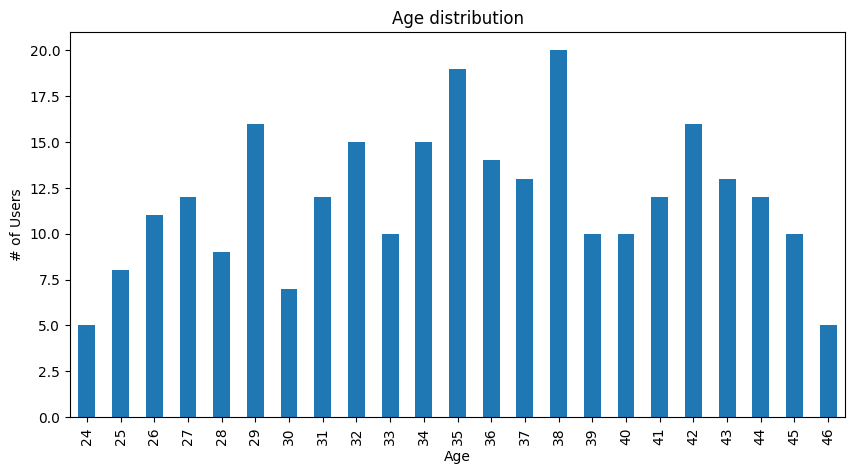

In [27]:
if not is_dataFrame('user_df'):
    load_tables()

def age(birthdate):
    dob = to_datetime(birthdate).date() if type(birthdate) is not str \
                  else dateutil.parser.parse(birthdate).date()
    hoy = dateutil.utils.today().date()
    ddiff = hoy - dob
    edad  = int(ddiff.days / 365.25)
    # print(edad, "años")
    return edad

# Add age column to user dataframe
user_df["age"] = user_df['birthdate'].map(age)

age_distrib_graph = user_df.groupby('age')['age'] \
        .count() \
        .plot.bar(
            x='age',
            figsize=(10,5),
            title="Age distribution",
            ylabel="# of Users",
            xlabel="Age"
        )

Observando la gráfica, vemos que no hay una distribución uniforme y, por tanto, podría decirse que las edades son "aleatorias" en su distribución, quizá con una prevalencia en la franja de 26 a 29 años, pero no es significativa. Eso sí, no hay gente mayor de 50 ni jóvenes de 18 a 23. Es... atípico. O:)

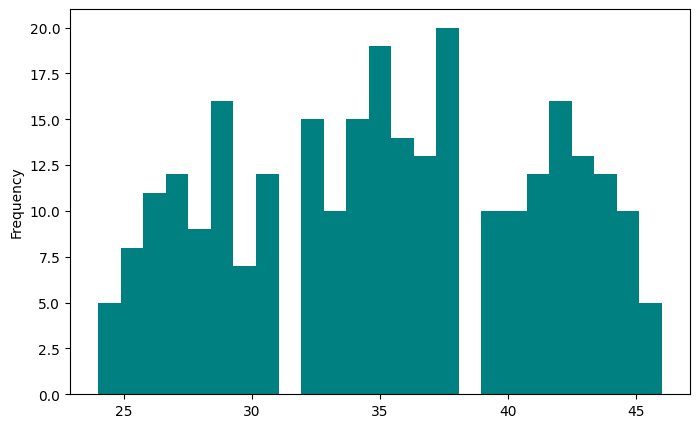

In [8]:
age_distrib_histogram = user_df['age'].plot.hist(bins=25, figsize=(8,5), color='teal')

#### T8.01 N1E2 dues variables numèriques
Relacionamos las ventas con la edad de los compradores. Vemos que los más jóvenes, y el grupo de los treinta (33, y 34 años los que más) y curiosamente los que han cumplido los cuarenta, son los tres picos de compradores.

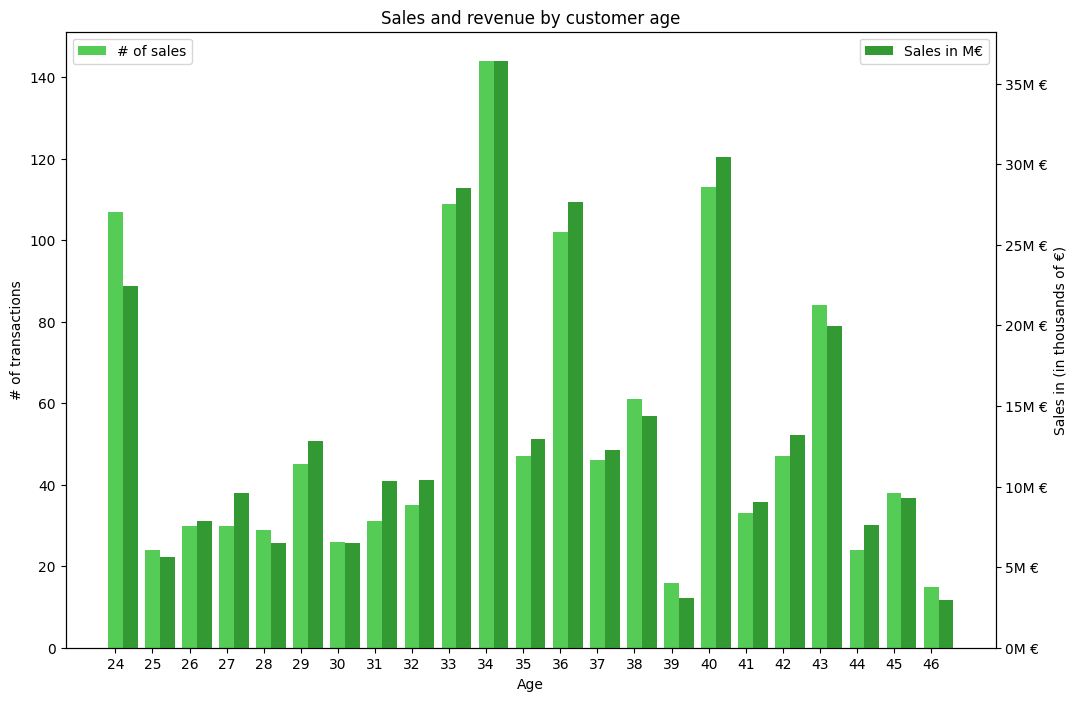

In [28]:
load_tables()

# user_df['Client'].head()

# Create the custom dataset with user and transasction data
productos = prtr_df.merge(
                       tr_df[tr_df['declined']==0].filter([
                           'transaction_id',
                           'amount',
                           'user_id']),
                       on="transaction_id",
                       how="inner"
                    ) \
                   .merge(user_df.filter([
                       'user_id',
                       'age'
                   ]), on="user_id", how="inner")

# productos.head()

salesXage    = productos.get(['age', 'amount']) \
                        .groupby('age')['amount'] \
                        .agg(['sum', 'count'])

# salesXage['sum'] /= 1000

f, sxa_gr = pyplot.subplots(figsize=(12,8))
ages_list = salesXage.index
bar_width = 0.4
positions = np.arange(len(ages_list))

sxa_gr.bar(
    x=positions,
    height=salesXage['count'], # transactions by age
    width=bar_width,
    label='# of sales',
    color='#5c5'
)
sxa_gr.set_xlabel('Age')
sxa_gr.set_ylabel('# of transactions')
sxa_gr.set_xticks(positions, [str(n) for n in ages_list])

sxa_gr2 = sxa_gr.twinx()
sxa_gr2.bar(
    x=positions+bar_width,
    height=salesXage['sum'] / 1000,
    width=bar_width,
    label='Sales in M€',
    color='#393'
)
sxa_gr2.set_ylabel('Sales in (in thousands of €)')
sxa_gr2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%dM €'))
# pyplot.bar(countBarPos, salesXage['count'], bar_width, label='')
# pyplot.bar(sumBarPos,   salesXage['sum'], bar_width, label='')

sxa_gr.set_title("Sales and revenue by customer age")
sxa_gr.legend(loc='upper left')
sxa_gr2.legend(loc='upper right')


#### T8.01 N1E3 Una variable categòrica
Podríamos utilizar el país y categorizar las compañías en base a su país. Aunque no es del tipo "dtype.Category", se podrían considerar los países como valores categóricos: no puede haber países que no existen, por ejemplo.

De todos los países listados, vemos que España, país cuya economía no se basa en la fabricación de bienes de consumo es el país peor colocado en cuanto al número de vendedores. china le sigue, quizá por las restricciones impuestas a su mercado exterior, tanto interna como exteriormente, que hacen que el comercio exterior se realice como mayorista.  
Sorprende Francia, pero quizá se deba a que las "especialidades francesas" no sean el tipo de productos que se venden en la platafroma.

Hablando de sorpresas: aunque por supuesto no sorprende que los EE.UU. y el Reino Unido estén entre los que mayos número de vendedores estáninscritos, sí lo es Italia. De nuevo, es probable que los mercados europeos vendas productos chinos, mientras China, como tal, mantiene bajo el número de empresas de venta al por menor, o venta directa al consumidor.

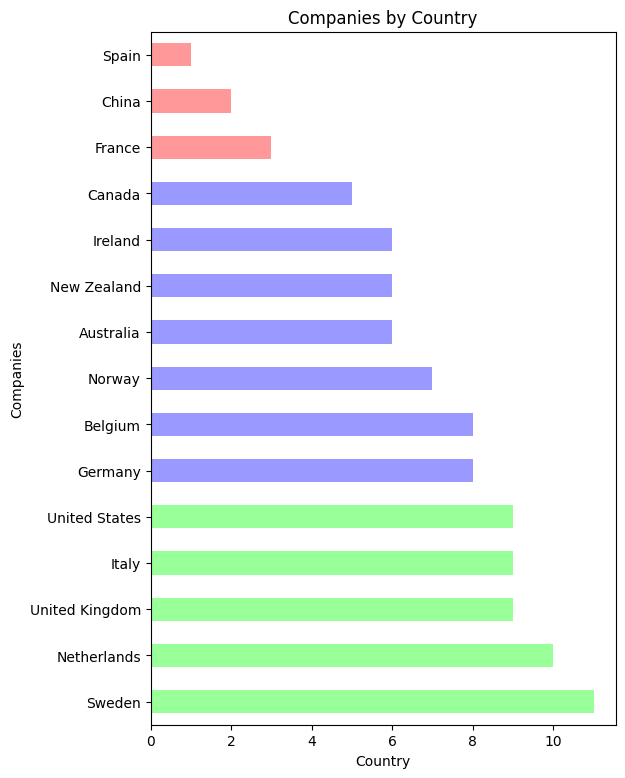

In [10]:
load_tables()

pastel_3colors = {4: '#f99', 8: '#99f', 'else': '#9f9'}
graph_data     = co_df.groupby('country')['country'] \
                      .count()  \
                      .sort_values(ascending=False) # comment or set to modify order

co_by_country = graph_data.plot.barh(
            title="Companies by Country",
            figsize=(6,9),
            x='age',
            ylabel="Companies",
            xlabel="Country",
            color=column_colors(graph_data, pastel_3colors)
        )

Otra variable categórica es el estado de la transacción, ya que solo puede tener dos estados.

Al principio, hice este gráfico partiendo de una consulta:

C:\Users\formacio\AppData\Local\Temp\ipykernel_6308\3579463936.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db, columns=['declined'])


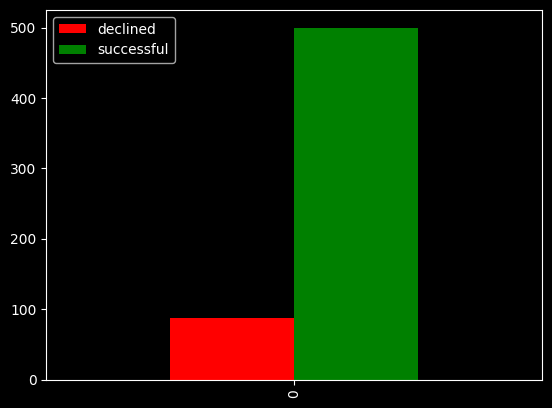

In [132]:
load_tables()

query = '''
SELECT SUM(declined)   AS declined
     , SUM(declined=0) AS successful
  FROM `transaction`
'''

if 'db' in globals() and db.is_connected:
    df = pd.read_sql(query, con=db, columns=['declined'])
    df.plot.bar(color=['red','green'])

Pero supongo que si se trata de usar pandas, la idea es hacer la selección y agregación usando la biblioteca y no SQL, ya que la "_gracia_" está en importar datos de Excel/hojas de cálculo, tablas HTML, CSV... donde no hay cómo hacer un GROUP BY o un MAX().
(Esto no se dice tampoco en el enunciado... Solo "conectar a la DB"; si conecto a una DB para hacer un select, a algunos la manipulación se nos va directamente a SQL).

---

Sin entrar en detalles geopolíticos, vemos que la granmayoría de las transacciones finalizan correctamente. Aun así, la cantidad parece excesiva, y conviende realizar un análisis de los motivos de la declinación de las transacciones, pues hablamos de casi un veinte por ciento de transacciones que no finalizan y, aunque de estas seguramente hayan reintentos exitosos, queda por determinar tanto el volumen como el motivo, para saber cómo reducir esta mala experiencia de usuario.

<Axes: title={'center': 'Transactions'}, xlabel='Status', ylabel='# of transactions'>

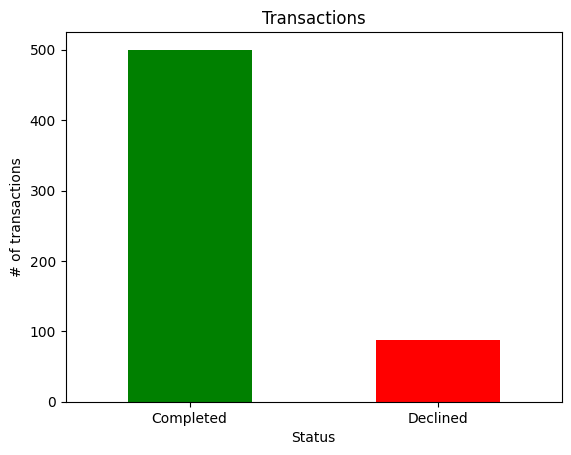

In [11]:
# Usando pandas para "calcular" las columnas, y crear el gráfico renombrando las columnas de "0" y "1" a "Completadas" y "Declinadas"ArithmeticErrordecl_df = tr_df.groupby('declined').count()
decl_df = tr_df.groupby('declined').count()

decl_df = decl_df.rename({0: "Completed", 1: "Declined"}, axis='index')['transaction_id']
# decl_df = decl_df['transaction_id']
# print(decl_df)
decl_df.plot.bar(
    title="Transactions",
    xlabel="Status",
    ylabel="# of transactions",
    color=['green', 'red'],
    rot=0
)

#### T8.01 N1E4 Una variable categòrica i una numèrica
¿Total y cantidad de compras por mes? En una gráfica doble... Hmmm... ¿El mes es una variable categórica o numérica? Si fueran fechas, diría que "más o menos numéricas", sin embargo, al agrupar por mese, estamos categorizando los datos, ¿no?
---
Las ventas mensuales, vistas en su conjunto, apuntan a que solo el mes de marzo es realmente malo. No ayuda que no haya ninguna festividad relevante en este mes, como sí los hay en febrero, julio o noviembre (aunque las compras para las festividades de noviembre se realizan a mediados o finales de octubre), no digamos ya diciembre, donde las ventas se producen a principios de mes, sobre todo, haciendo que este sea el mes de mayor movimiento. después de abril (el festivo de mayo es en la primera, o segunda, semana del mes, haciendo que las ventas estén en abril en su mayoría, de forma similar a lo que ocurre en octubre).

[]

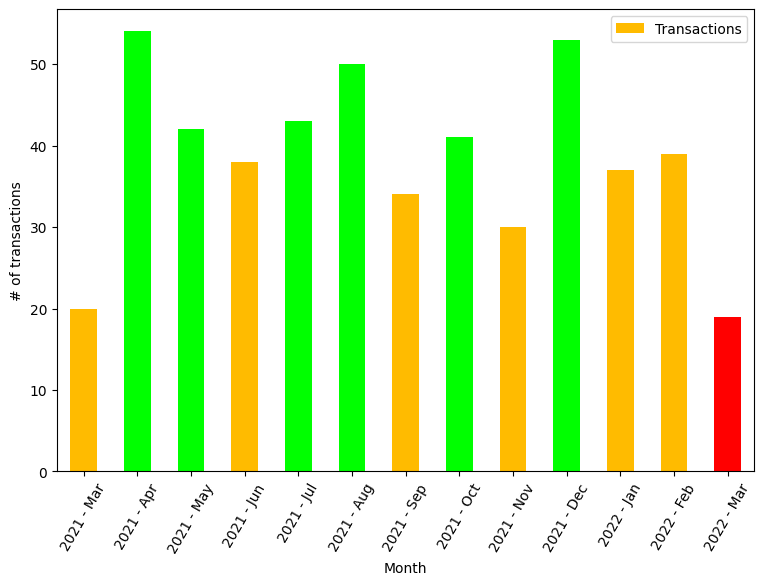

In [18]:
load_tables()

tr_df_agg  = tr_df[tr_df['declined']==0]  \
                        .loc[:, ['amount', 'transaction_ts']]  \
                        .groupby(pd.Grouper(
                            key='transaction_ts',
                            axis=0,
                            origin='start',
                            sort=True,
                            freq='ME'
                        )) \
                        .agg(['sum', 'count'])
tr_agg     = tr_df_agg['amount']
bar_values = tr_agg['count'].to_list()

semaphor_colors = {
    20:     '#f00',
    40:     '#fb0',
    'else': '#0f0'
}
cc     = column_colors(bar_values, semaphor_colors)
xticks = [d.date().strftime('%Y - %b') for d in tr_agg.index]

graph = tr_agg['count'].plot.bar(
    figsize=(9,6),
    color=cc,
    rot=60,
    ylabel="# of transactions",
    xlabel="Month",
    label="Transactions"
)
graph.set_xticks(range(0, xticks.__len__()), xticks)
graph.legend(["Transactions"])
graph.plot()

In [ ]:
load_tables()

tr_df_agg  = tr_df[tr_df['declined']==0]  \
                        .get(['amount', 'transaction_ts'])  \
                        .groupby(pd.Grouper(
                            key='transaction_ts',
                            axis=0,
                            origin='start',
                            sort=True,
                            freq='ME'
                        )) \
                        .agg(['sum', 'count'])
tr_agg     = tr_df_agg['amount']
bar_values = tr_agg['count'].to_list()

semaphor_colors = {
    20:     '#f00',
    40:     '#fb0',
    'else': '#0f0'
}
cc = column_colors(bar_values, semaphor_colors)

xticks = [d.date().strftime('%Y - %b') for d in tr_agg.index]



#### T8.01 N1E5 Dues variables categòriques
Podríamos ver, siguiendo con resulado de transacciones y países, podemos preguntarnos por el resultado de las transacciones por país.
---
Como decíamos en un punto anterior, habría que analizar mejor el resultado de las transacciones, pues hay cerca de un 20% de operaciones noo finalizadas y no puede ser bueno. Pero sorprende en este análisis que muchos países tienen un ratio cercano al 50% de operaciones declinadas. Esto es preocupante. Que esto ocurra en los EE.UU. que tiene una larga tradición de compra on-line y con tarjeta, es cuando menos extravagante; pero Australia y Francia, dos países con una población educada y activa tienen ese 50%, junto con España, donde de las 4 transacciones registradas, 2 han fallado (las dos con éxito son reintentos, muy probablemente, con éxito; hay que revisar esto, pero no disponemos de los datos del motivo del rechazo).

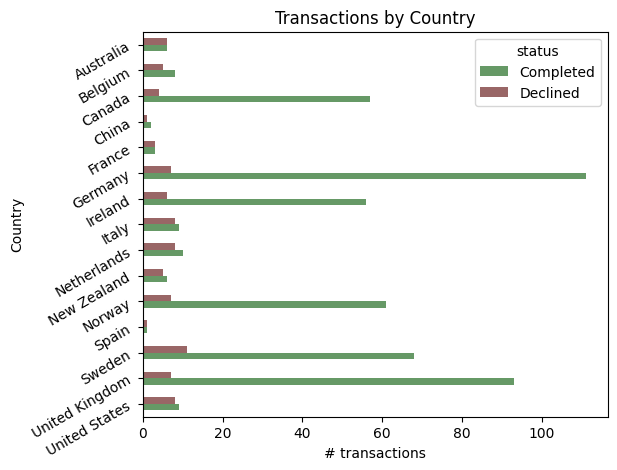

In [13]:
# Create the custom dataset with companies (country) and transasction data (declined)
cotr_df = tr_df.filter([
                    'declined',
                    'company_id'
                ]) \
                .merge(co_df.filter([
                        'company_id',
                        'country'
                    ]),
                    on="company_id",
                    how="inner"
                )
cotr_df['status'] = cotr_df['declined'].map({0: "Completed", 1: "Declined"})

graph_data = cotr_df.groupby(['country', 'status']) \
                    .size() \
                    .unstack(fill_value=0) \
                    .sort_values(by='country', ascending=False)
# print(cotr_df.head(10))
# print(graph_data.head(10))

tr_by_co = graph_data.plot.barh(
    title='Transactions by Country',
    figsize=(6,5),
    ylabel='Country',
    xlabel='# transactions',
    color=['#696', '#966'],
    rot=30
)

#### T8.01 N1E6 Tres variables
Aquí tenemos un agrupamiento por **país**, y mostrando la **cantidad de transacciones** _y_ el **valor** de dichas operaciones.

In [121]:
cotr_df = co_df.merge(tr_df, how='inner', on='company_id')
cotr_df.head()

,company_id,company_name,phone,email,country,transaction_id,user_id,credit_card_id,product_ids,transaction_ts,amount,latitude,longitude,declined
0,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,108B1D1D-5B23-A76C-55EF-C568E49A05DD,275,CcU-2938,b'[59]',2021-07-07 17:43:16,293.57,83.7839,-178.8600,0
1,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,EA2C3281-C9C1-A387-44F8-729FB4B51C76,275,CcU-2938,"b'[59, 79, 37, 73]'",2021-05-09 10:25:08,119.36,20.2004,-116.8400,1
2,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,7DC26247-20EC-53FE-E555-B6C2E55CA5D5,275,CcU-2945,"b'[71, 41]'",2022-02-04 15:52:56,312.50,58.9367,-76.8171,0
3,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,FE96CE47-BD59-381C-4E18-E3CA3D44E8FF,275,CcU-2945,b'[3]',2021-06-15 00:26:29,480.13,-21.8805,-112.5880,1
4,b-2230,Fusce Corp.,08 14 97 58 85,risus@protonmail.edu,United States,72997E96-DC2C-A4D7-7C24-66C302F8AE5A,275,CcU-2952,"b'[97, 41, 3]'",2022-01-30 15:16:36,239.87,43.3584,-17.6580,0


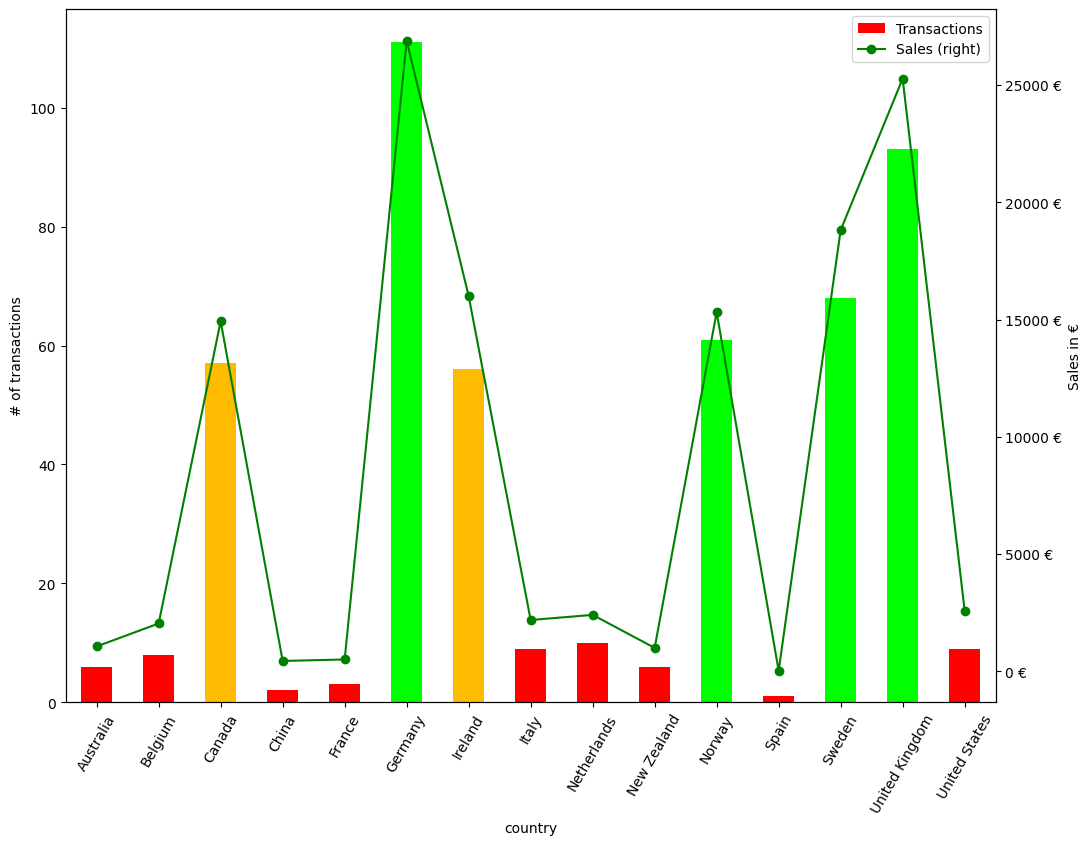

In [16]:
cotr_df = co_df.merge(tr_df, how='inner', on='company_id')

tr_agg  = cotr_df[cotr_df['declined']==0]  \
                        .loc[:,['amount', 'country']]  \
                        .groupby('country')  \
                        .agg(['sum', 'count'])

fig, ax = pyplot.subplots()
xLabels = tr_agg['amount'].index

semaphor_colors = {
    20:     '#f00',
    60:     '#fb0',
    'else': '#0f0'
}

cc = column_colors(tr_agg['amount']['count'], semaphor_colors)
# print(cc)
# print(tr_agg.head())

graph = tr_agg['amount']['count'].plot(
    kind="bar",
    figsize=(12,9),
    color=cc,
    rot=60,
    ylabel="# of transactions",
    label="Transactions",
    legend=True,
    ax=ax
)
# graph.legend(labels=("Transactions", "Sales"))

# Ventas en otra escala, para que sea visible...
graph2 = tr_agg['amount']['sum'].plot(
    kind='line',
    secondary_y=True,
    legend=True,
    ylabel='Sales in €',
    color='green',
    marker='o',
    rot=60,
    label="Sales",
    ax=graph
)
graph2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d €'))

En este gráfico superior, la línea indica los importes de las transacciones; cuando más separada de la barra que indica el número de transacciones, más caros son los productos comprados, _grosso modo_. También puede darse el caso de estar por debajo de la barra, en cuyo caso indicaría quie son productos de bajo precio. En Alemania, por ejemplo, está equilibrado, mientras que los demás países están ligeramente por encima.

#### T8.01 N1E7 Graficar un Pairplot
Seleccionar una "tabla" (data frame) y crear el gráfico. Se supone que la biblioteca seaborn se encarga de casi todo...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


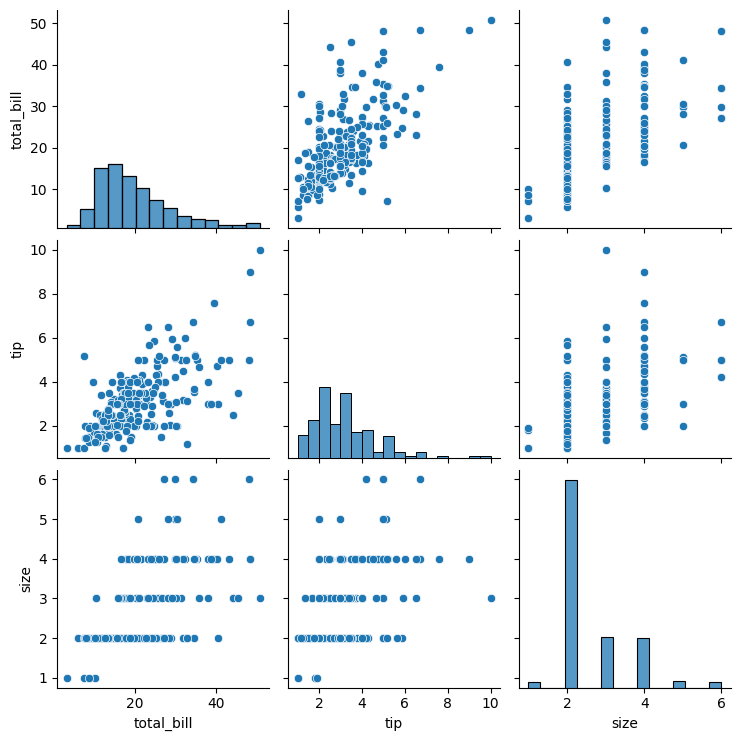

In [20]:
import seaborn as sbn

df = sbn.load_dataset('tips')
df.info()

sbn.pairplot(df)

Vale, esto de arriba es el ejemplo. He completado el ejercicio... :-D

Lo suyo, imagino, es utilizarlo con el dataset del resto del nivel. ;-)

Podríamos seleccionar Users, para ver qué nos puede decir de los compradores.

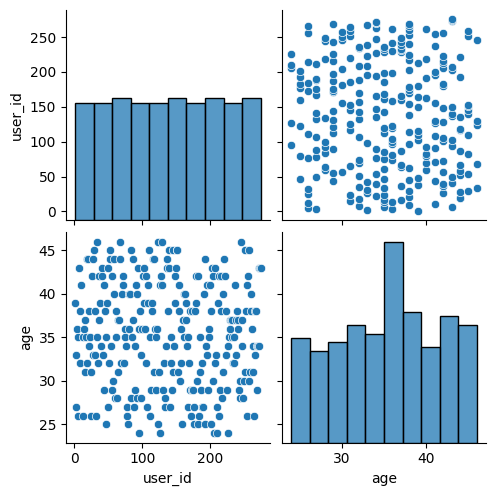

In [29]:
salesXage['age'] = salesXage.index

sbn.pairplot(user_df)

Pero ahí no hay donde rascar, porque casi toda la información es ... individual. ASí que nos vamos a por una de las matrices de datos creadas en un ejercicio anterior: las ventas por edades, y aquí al menos hay algo que puede interesar... o no.

Este gráfico muestra la dispersión entre las tres variables, indicando que hay muchas ventas (Sales) de valores bajos y que se corresponden a la mayoría de los ingresos (Revenue), mientras que las ventas de productos de mayor valor son muy pocas. Las ventas por edades ya las hemos analizado antes, y aquí se repite el patrón.

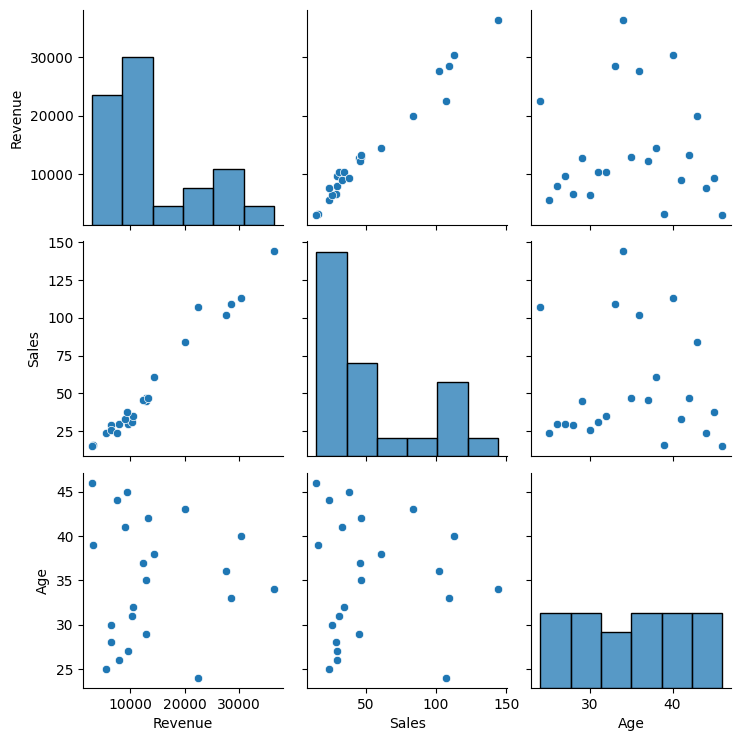

In [30]:

sbnSalesXage = salesXage.rename(columns={
    'count': 'Sales',
    'sum': 'Revenue',
    'age': 'Age'
})
sbn.pairplot(sbnSalesXage)

## Nivel 2

### S8.01 N2E1 Correlación entre todas las variables numéricas
Primero, unir (`merge()`) las tablas o matrices de datos con las columnas numéricas que haya, ignorando, claro, los IDs que puedan ser numéricos (creo que solo user_id lo es, pero revisemos).

Básicamente, tenemos:

Tabla       |  DF   | numcols        | descartadas
------------|:-----:|----------------|---
transaction | tr_df | amount         | user_id, latitude, longitude
product     | pr_df | price, weight  | product_id

El resto no tiene variables numéricas útiles. Así que queda crear un heatmap con la tabla de correlación de estas, después de relacionar transacciones y productos, una matriz de datos que podemos crear a partir de prtr_df.


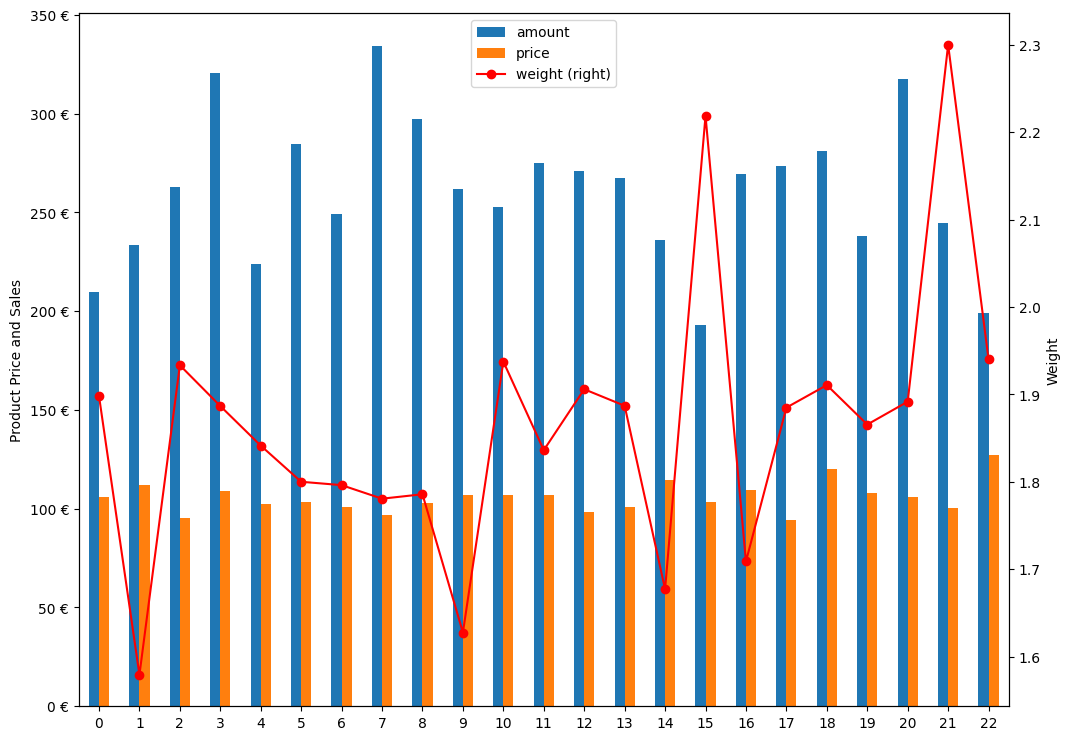

In [34]:
# enable dark mode
# pyplot.style.use('dark_background')
trproductos = prtr_df.merge(tr_df[tr_df['declined']==0].filter([
                        'transaction_id',
                        'product_id',
                        'amount',
                        'user_id']
                    ), on="transaction_id", how="inner") \
                   .merge(user_df.filter([
                        'user_id',
                        # 'transaction_id',
                        # 'product_id',
                        'amount',
                        'age'
                   ]), on="user_id", how="inner") \
                   .merge(pr_df.filter([
                       'product_id',
                       'weight',
                       'price',
                       'product_name'
                   ]), on="product_id", how="inner")

# print(list(set(productos)))
cols = ["product_name", "amount", "weight", "price", "age"]

product_aggs = {"amount": "mean", "weight": "mean", "price": "mean"}
plotData2 = plotData[['amount', 'weight', 'price', 'age']] \
                .groupby("age") \
                .mean() #agg(by=product_aggs)

plotData2.reset_index(inplace=True)
# type(plotData2)
# print(plotData2)

fig, ax = pyplot.subplots()

graph = plotData2[['amount', 'price']].plot(
    kind="bar",
    ax=ax,     # <- igual que en el ejemplo de tr_agg
    # color=cc,
    ylabel="Product Price and Sales",
    legend=True,
)

graph2 = plotData2[['weight']].plot(
    kind="line",
    ax=graph,
    legend=True,
    figsize=(12,9),
    secondary_y=True,
    ylabel="Weight",
    color="red",
    marker="o",
    label="Weight"
)

graph.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d €'))

### S8.01 N2E2 Implementa un jointplot.

Por lo que he visto, un [JointPlot](https://seaborn.pydata.org/generated/seaborn.jointplot.html) es uno de los gráficos que puede generar SeaBorn.

La idea es tener un scatterplot central y mostrar la relación de los puntos con dos variables en el exterior, mostrando de dónde sale la posición de los puntos de acuerdo con los datos de las variables...

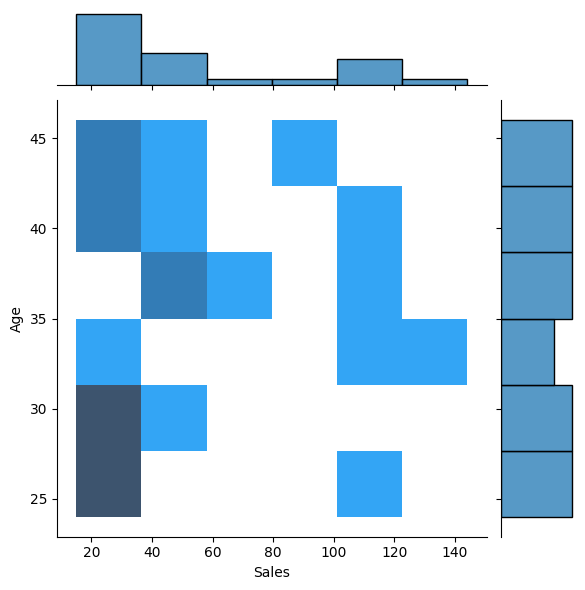

In [35]:
e = sbn.jointplot(
    data=sbnSalesXage,
    y='Age',
    x='Sales',
    kind='hist'
)

### S8.01 N3E1 ViolinPlot
> Implementa un violinplot combinat amb un altre tipus de gràfic.

Qué es un [Violin plot](https://en.wikipedia.org/wiki/Violin_plot)? Se puede generar con [SeaBorn](https://seaborn.pydata.org/generated/seaborn.violinplot.html), también.

Aquí sería crear un violin plot de las transacciones, mostrando el "movimiento" por países. A ver qué sale.

In [36]:
cotr_df.head(3)

,company_id,company_name,phone,email,country,transaction_id,user_id,credit_card_id,product_ids,transaction_ts,amount,latitude,longitude,declined
0,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,108B1D1D-5B23-A76C-55EF-C568E49A05DD,275,CcU-2938,b'[59]',2021-07-07 17:43:16,293.57,83.7839,-178.8600,0
1,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,EA2C3281-C9C1-A387-44F8-729FB4B51C76,275,CcU-2938,"b'[59, 79, 37, 73]'",2021-05-09 10:25:08,119.36,20.2004,-116.8400,1
2,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,7DC26247-20EC-53FE-E555-B6C2E55CA5D5,275,CcU-2945,"b'[71, 41]'",2022-02-04 15:52:56,312.50,58.9367,-76.8171,0


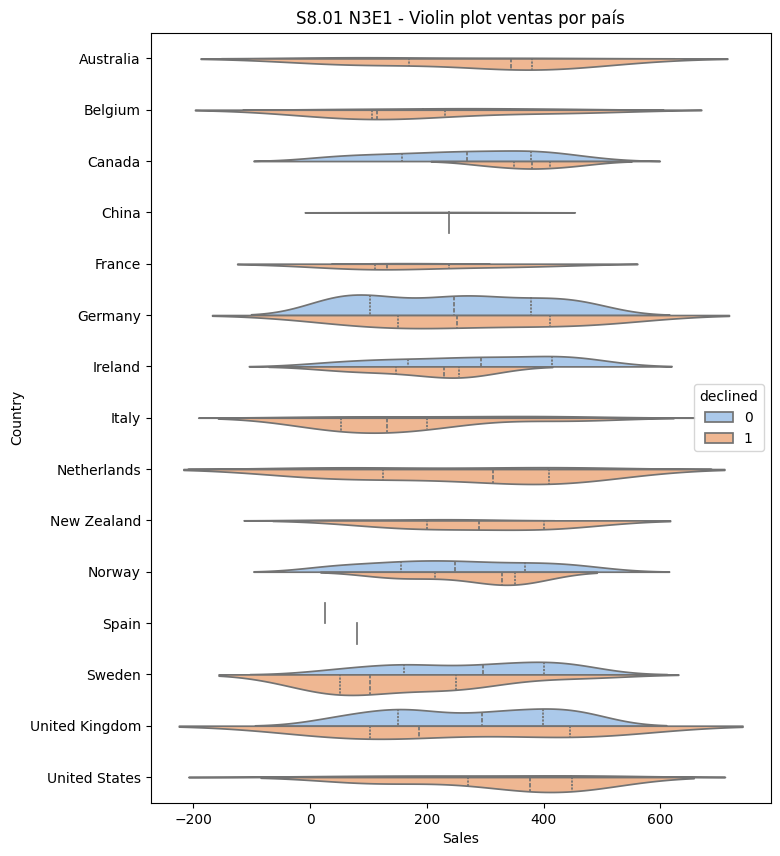

In [37]:
import matplotlib.pyplot as plt

pl = plt.figure(figsize=(8,10))
cotr_df['country'] = cotr_df['country'].astype("category")
vp = sbn.violinplot(
    cotr_df,
    x='amount',
    y="country",
    hue='declined', split=True,
    palette="pastel",
    inner="quart",
    density_norm='count',
)

vp = vp.set(
    title="S8.01 N3E1 - Violin plot ventas por país",
    xlabel="Sales",
    ylabel="Country",
)

### S8.01 N3E2 FacetGrid
> Genera un FacetGrid per a visualitzar múltiples aspectes de les dades simultàniament.

Un FacetGrid permite presentar diferentes aspectos de un mismo conjunto de datos. Algo como el pairpilot, pero con más control.

En este caso, intento mostrar diferentes aspectos de las transacciones, teniendo en cuenta si fueron declinadas y también por día de la semana y la hora de la transacción.

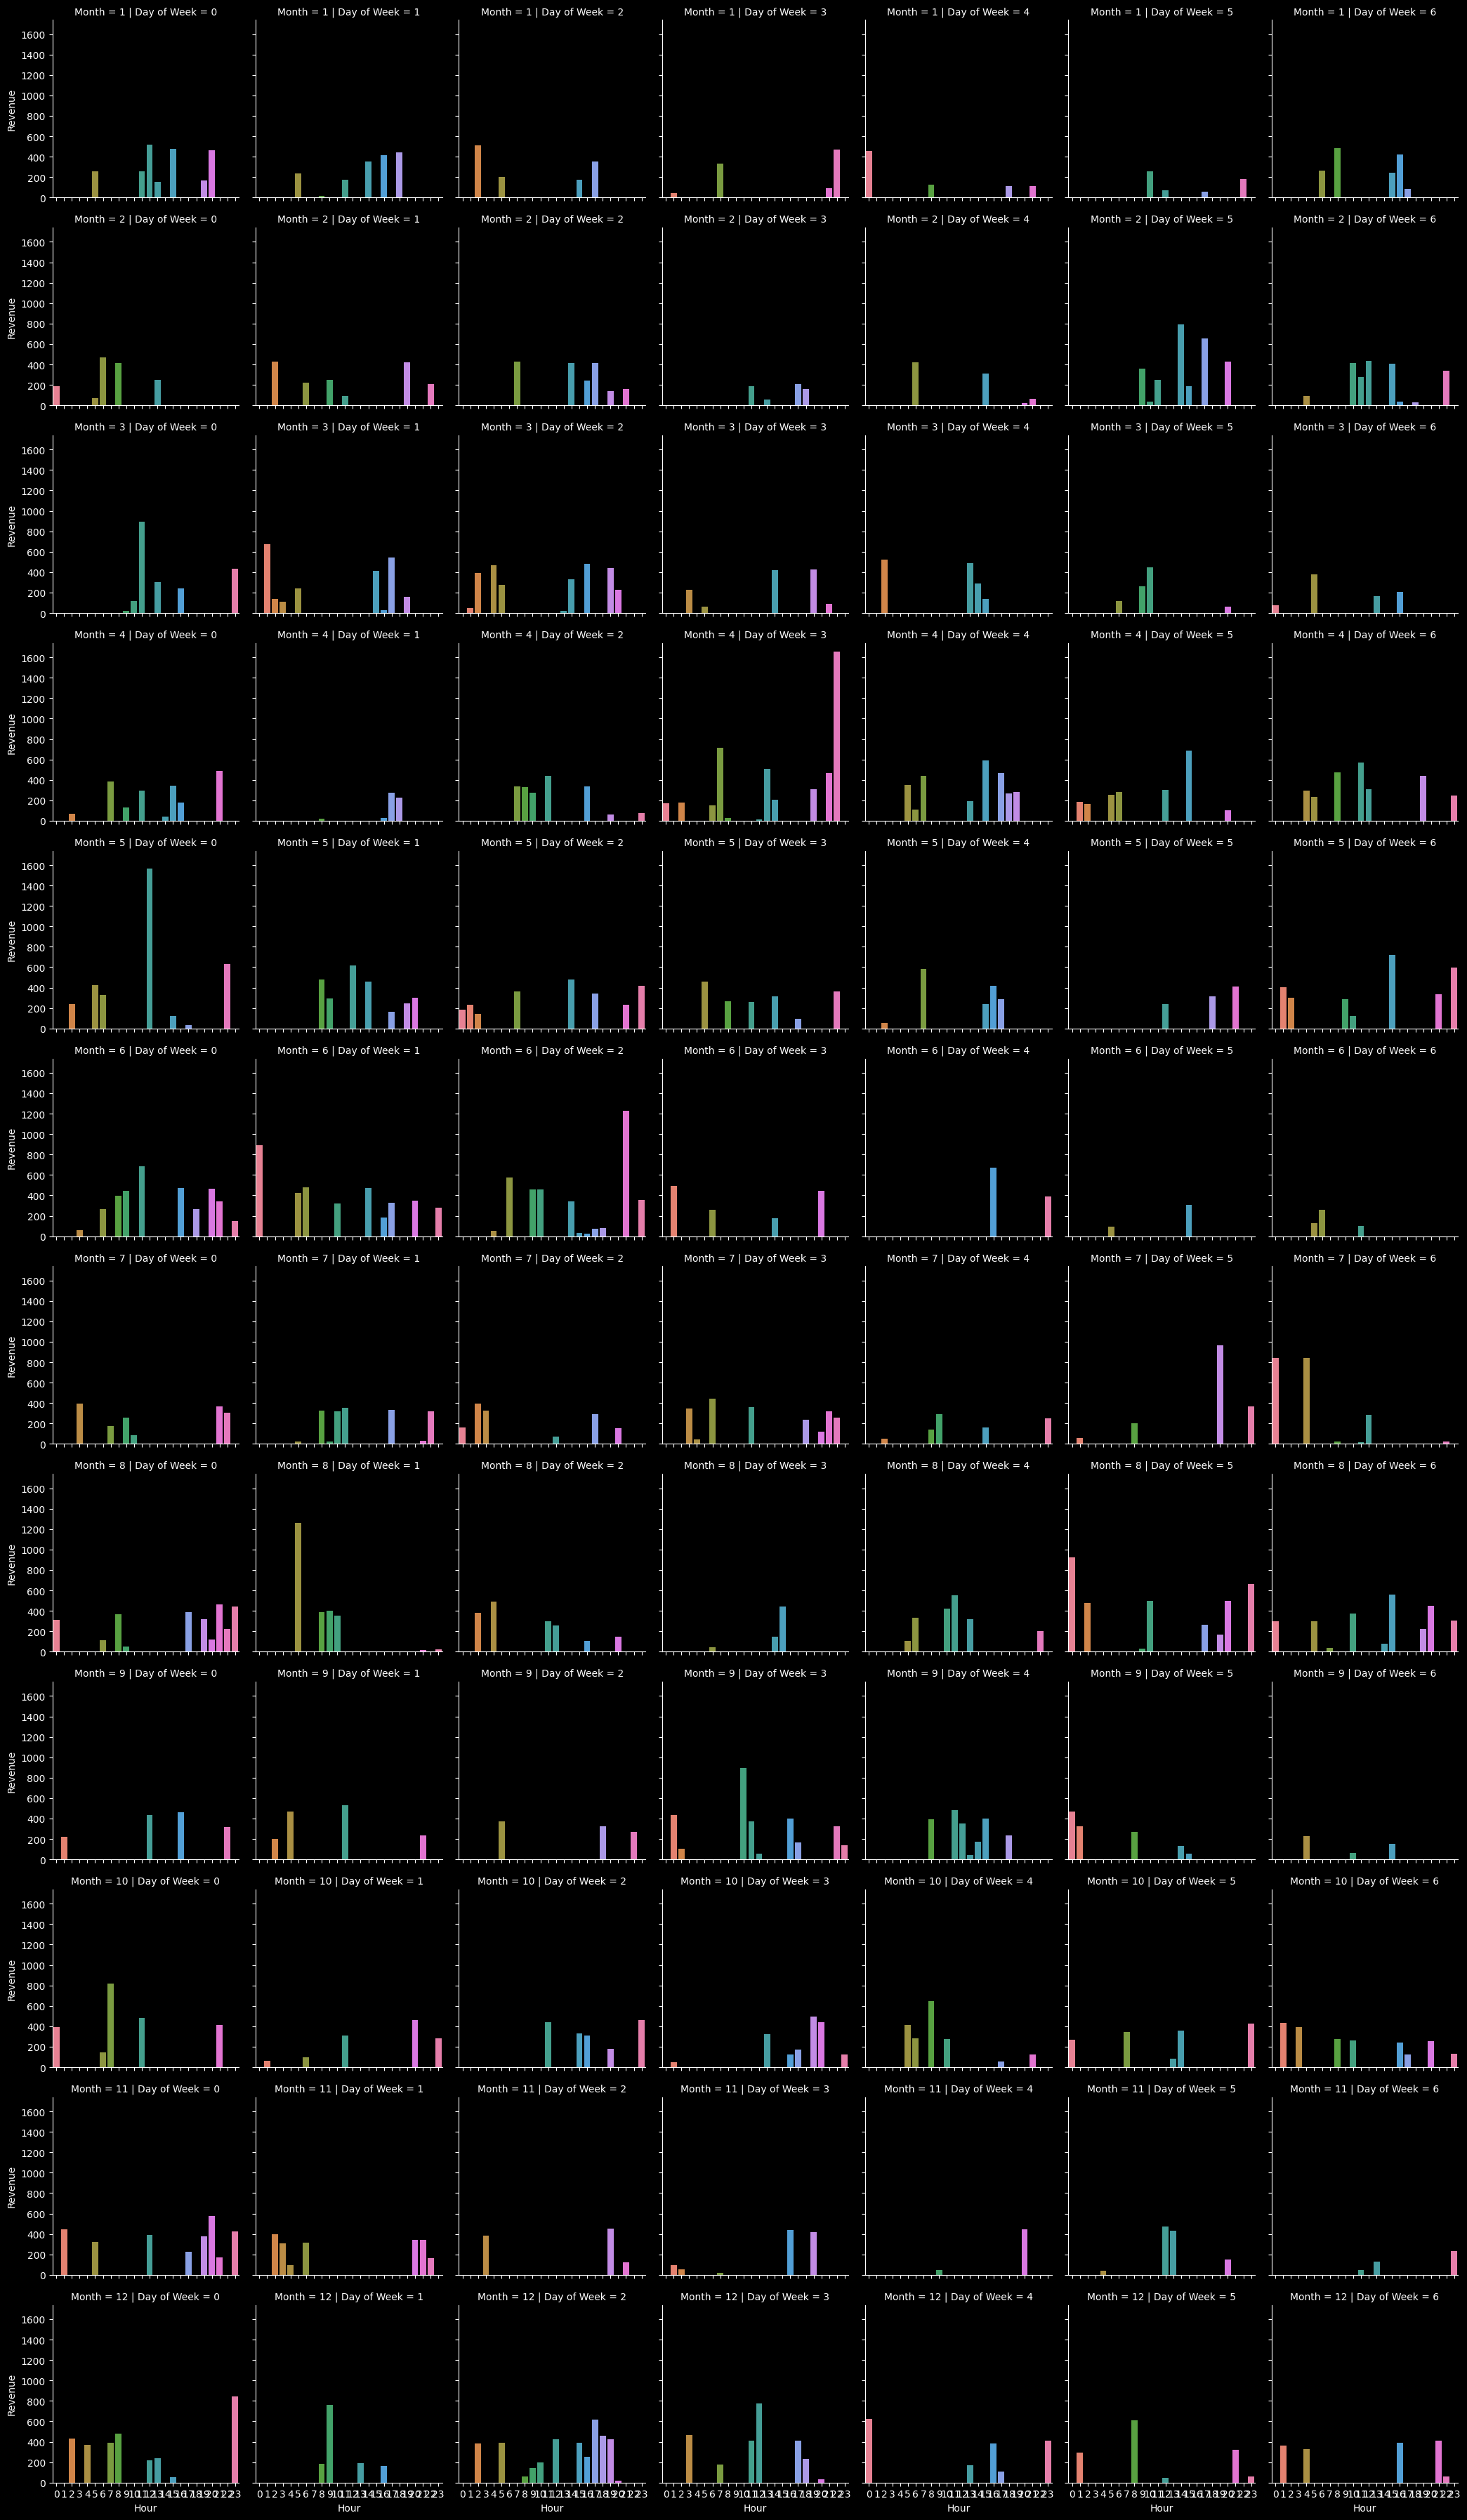

In [131]:
fg_data = cotr_df.groupby([
    cotr_df['transaction_ts'].dt.month,
    cotr_df['transaction_ts'].dt.day_of_week,
    cotr_df['transaction_ts'].dt.hour]) \
    .amount.sum()

# No he visto una forma de "desindexar" o "aplanar" la serie,
# así que he tirado de bucles.
mil = fg_data.index.levels # multiindexes. 0=month, 1=DOW, 2=hour
fg_df_raw = []
for mes in mil[0]:
    for dow in mil[1]:
        for hora in mil[2]:
            fg_df_raw.append([
                mes,
                dow,
                hora,
                fg_data[(mes, dow,hora)]
                    if (mes, dow, hora) in fg_data.keys()
                    else 0
            ])

fg_df = pd.DataFrame(
    fg_df_raw,
    columns=['Month', 'Day of Week', 'Hour', 'Revenue']
)

# fg_df.head(10)
fgd = sbn.FacetGrid(
    fg_df,
    col='Day of Week',
    row='Month',
    hue='Hour'
)  # creates the object, no plot yet

fgd.map_dataframe(sbn.barplot, y='Revenue', x='Hour')